# Data Modelisation

- Configuration

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from nlp_module import remove_stopwords, plot_top_words
import sklearn
from nltk.tokenize.toktok import ToktokTokenizer
from gensim.models import CoherenceModel, Nmf
from gensim.corpora import Dictionary
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pyLDAvis
import pyLDAvis.sklearn

In [2]:
sklearn.set_config(display="diagram")

## 1) Data preparation

In [3]:
data = pd.read_csv("datasets/posts_clean.csv")
data.head(3)

,Id,Title,Body,Tags
0,415192,good way create simple python web service,I use python year I little experience python w...,<python><web-services>
1,415344,log implementation prefer,I implement log class c try decide I curious k...,<debugging><language-agnostic><logging>
2,414981,directly modify list element,I struct struct map public int size public map...,<c#><.net>


In [4]:
# remove < and > around Tags
data["Tags"] = data["Tags"].replace({"<" : " "}, regex=True)
data["Tags"] = data["Tags"].replace({">" : " "}, regex=True)

In [5]:
data["Body"] = data["Body"].str.lower()
data["Body"] = data["Body"].apply(remove_stopwords)

In [6]:
data.isnull().mean()

Id       0.000000
Title    0.000061
Body     0.000000
Tags     0.000000
dtype: float64

In [7]:
data.dropna(inplace=True)

In [8]:
data.head(3)

,Id,Title,Body,Tags
0,415192,good way create simple python web service,use python year little experience python web p...,python web-services
1,415344,log implementation prefer,implement log class c try decide curious know ...,debugging language-agnostic logging
2,414981,directly modify list element,struct struct map public int size public map i...,c# .net


In [9]:
docs = data["Title"] + " " + data["Body"]

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [11]:
# Materialize the sparse data
data_dense = tfidf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  3.6929259727319126 %


## 2) Topic Modelling

### a) Non Negative Matrix Factorization (NMF)

In [12]:
best_num_topics = 10

In [13]:
nmf = NMF(n_components=best_num_topics,
          random_state=42,
          alpha=0.1)

In [14]:
nmf.fit(tfidf)

NMF(alpha=0.1, n_components=10, random_state=42)

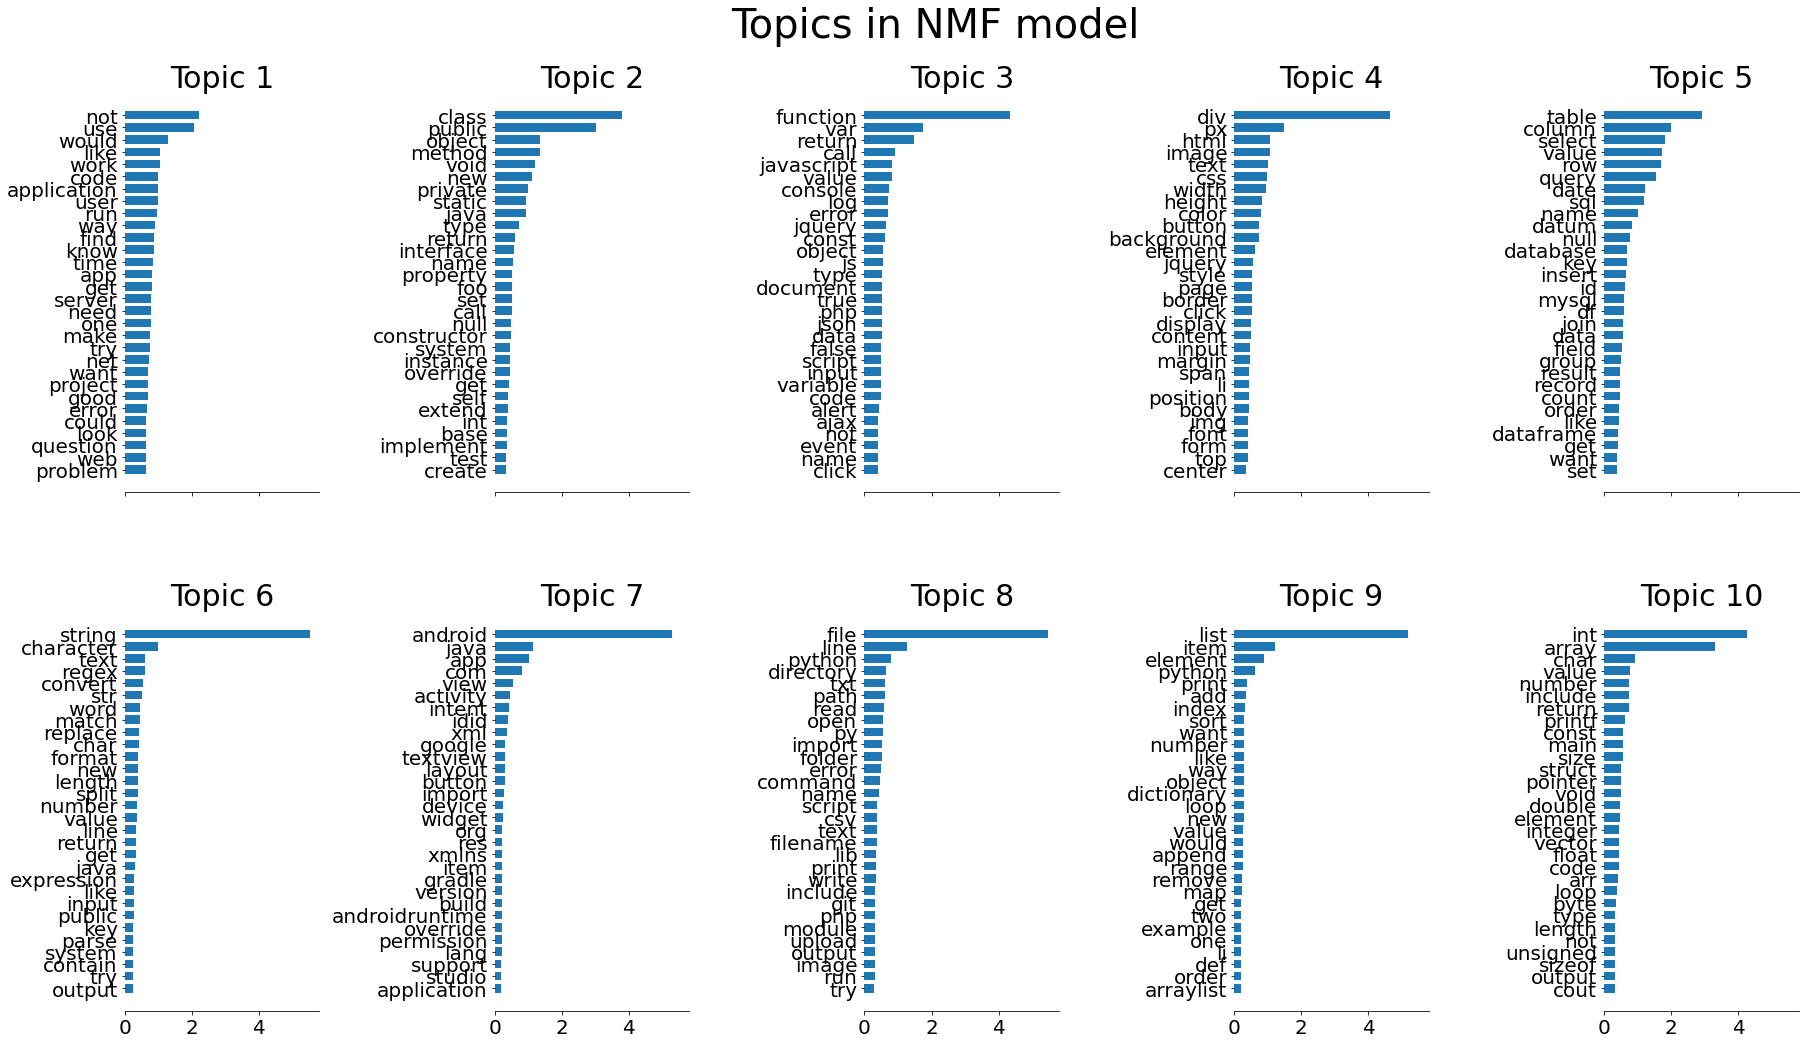

In [15]:
plot_top_words(nmf, tfidf_feature_names, n_top_words=30, title="Topics in NMF model")

### b) Latent Dirichlet Allocation (LDA)

In [16]:
lda = LatentDirichletAllocation(random_state=42,
                                n_jobs=-1)

In [17]:
params = {'n_components' : [8, 9, 10, 11],
          'learning_method' : ["online", "batch"],
          'learning_decay' : [0.6, 0.7, 0.8, 0.9]}


gridsearch_lda = GridSearchCV(lda,
                              param_grid=params,
                              cv=5)
gridsearch_lda.fit(tfidf)

GridSearchCV(cv=5,
             estimator=LatentDirichletAllocation(n_jobs=-1, random_state=42),
             param_grid={'learning_decay': [0.6, 0.7, 0.8, 0.9],
                         'learning_method': ['online', 'batch'],
                         'n_components': [8, 9, 10, 11]})

In [19]:
best_lda_model = gridsearch_lda.best_estimator_

print("Best Model's Params: ", gridsearch_lda.best_params_)

print("Best Log Likelihood Score: ", gridsearch_lda.best_score_)

Best Model's Params:  {'learning_decay': 0.6, 'learning_method': 'batch', 'n_components': 8}
Best Log Likelihood Score:  -1041464.7468262867


In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, tfidf, tfidf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3     -108.958252 -208.941483       1        1  15.846297
7      186.487061  -98.103249       2        1  14.182502
1       19.245832  160.858780       3        1  13.173734
4      170.658829   75.445076       4        1  12.592014
5       -1.386411  -35.043739       5        1  12.394848
6     -145.800095  106.944611       6        1  12.019917
0       64.834541 -221.825272       7        1  10.366920
2     -196.906036  -58.990913       8        1   9.423768, topic_info=       Term         Freq        Total Category  logprob  loglift
252     div  2279.000000  2279.000000  Default  30.0000  30.0000
692  public  2789.000000  2789.000000  Default  29.0000  29.0000
449     int  3592.000000  3592.000000  Default  28.0000  28.0000
336    file  4620.000000  4620.000000  Default  27.0000  27.0000
147  column  1972.000000  1972.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
592     not   426.907729  6675.293118   Topic8  -5.0732  -0.3877
936     use   413.331701  6000.987138   Topic8  -5.1055  -0.3135
507    list   381.111506  3133.352053   Topic8  -5.1867   0.2552
379     get   386.567223  4058.813681   Topic8  -5.1725   0.0106
56    array   366.942292  2932.811800   Topic8  -5.2246   0.2834

[476 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.002836  abc
0         2  0.518936  abc
0         3  0.028357  abc
0         4  0.065221  abc
0         5  0.056714  abc
...     ...       ...  ...
990       6  0.074526   x_
990       7  0.794939   x_
990       8  0.008281   x_
994       3  0.978039  xsl
994       7  0.015649  xsl

[2664 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 2, 5, 6, 7, 1, 3])

- Topic 1 : OS - Top topic
- Topic 2 : Script Language/Python
- Topic 3 : Web language/Front-end
- Topic 4 : Java
- Topic 5 : Web language/Back-end
- Topic 6 : SQL
- Topic 7 : Script Language
- Topic 8 : Data Analysis (Python)

In [45]:
import joblib
 
# Sauvegarde du modèle
joblib.dump(best_lda_model, 'lda_model.pkl')

['lda_model.pkl']

## 3) Supervised learning for text classification

In [51]:
from sklearn.model_selection import train_test_split

X = docs
y = data["Tags"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.25)

In [55]:
def tok(text):
    tokenizer = ToktokTokenizer()
    return tokenizer.tokenize(text)

In [56]:
vec_count = CountVectorizer(ngram_range = (1,1),
                            tokenizer=tok)
vec_count_f = vec_count.fit(X_train)

In [57]:
vec_f = vec_count_f
train_dtm = vec_f.transform(X_train)
topic_num = 8

lda = LatentDirichletAllocation(n_components = topic_num,
                               random_state=42,
                               learning_method="batch",
                               learning_decay=0.6)
lda_f = lda.fit(train_dtm)
lda_weights = lda_f.transform(train_dtm)

### a) Support Vector Machine

In [58]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)

In [ ]:
params = {"kernel" : ["linear", "rbf", "poly", "sigmoid"],
          "decision_function_shape" : ["ovr", "ovo"]}

grid_search = GridSearchCV(svm_clf, 
                           param_grid=params, 
                           scoring="accuracy",
                           cv=5)
grid_search.fit(lda_weights, y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_params_

### b) Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB(random_state=42)